# Lab 3.2 - Topic Modeling (Тематическое моделирование)

This notebook demonstrates the complete topic modeling pipeline:
1. Loading term-document matrix from Lab 2
2. LDA experiments with different numbers of topics
3. Perplexity analysis and polynomial approximation
4. Finding optimal number of topics
5. Document-topic probability analysis
6. Iteration count experiments



In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Add source directory to path
sys.path.append('source')

from source.data_loader import load_vocabulary_from_lab2, split_train_test
from source.topic_modeling import TopicModeler
from source.experiments import run_lda_experiments, run_iteration_experiments
from source.analysis import plot_perplexity_vs_topics, find_optimal_topics, polynomial_approximation

# Set up plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass
sns.set_palette("husl")

print("Libraries imported successfully!")


e:\D\AI\Semester 3\text processing\nlp-25\projects\mt-desta\lab3.2\source\data_loader.py:270: SyntaxWarning: invalid escape sequence '\d'
  dict_file = os.path.join(lab2_dir, 'assets\dictionaries', 'token_dictionary.json')
e:\D\AI\Semester 3\text processing\nlp-25\projects\mt-desta\lab3.2\source\data_loader.py:271: SyntaxWarning: invalid escape sequence '\m'
  matrix_file = os.path.join(lab2_dir, 'assets\matrices', 'term_document_matrix.pkl')


Libraries imported successfully!


## Step 1: Load Term-Document Matrix from Lab 2

Load the term-document matrix and vocabulary that were created in Lab 2 Task 1.


In [2]:
# Configuration
lab2_dir = "../lab2"
filter_stopwords = True  # Set to False to keep all words

# Load term-document matrix and vocabulary
print("Loading term-document matrix and vocabulary from lab2...")
if filter_stopwords:
    print("Stop word filtering: ENABLED")
else:
    print("Stop word filtering: DISABLED")

dict_data, term_doc_matrix, vocabulary = load_vocabulary_from_lab2(
    lab2_dir, 
    filter_stopwords=filter_stopwords
)

print(f"\nTerm-document matrix shape: {term_doc_matrix.shape}")
print(f"Vocabulary size: {len(vocabulary)}")
print(f"Number of documents: {term_doc_matrix.shape[1]}")
print(f"\nSample vocabulary words (first 20): {vocabulary[:20]}")


Loading term-document matrix and vocabulary from lab2...
Stop word filtering: ENABLED
Loading dictionary from ../lab2\assets\dictionaries\token_dictionary.json...
Loading matrix from ../lab2\assets\matrices\term_document_matrix.pkl...
Matrix format: (vocab_size, num_documents) = (35311, 121884)
Matrix shape: (35311, 121884) (vocab_size=35311, num_docs=121884)
Dictionary vocab_size: 35311
Filtering stop words...
Filtering stop words, digits, and single chars: 35311 -> 33449 tokens
Removed 1862 tokens (stop words, digits, single chars)
After filtering: matrix shape=(33449, 121884), vocabulary size=33449

Term-document matrix shape: (33449, 121884)
Vocabulary size: 33449
Number of documents: 121884

Sample vocabulary words (first 20): ['new', 'year', 'company', 'one', 'world', 'u.s.', 'report', 'week', 'game', 'last', 'yesterday', 'price', 'high', 'three', 'million', 'iraq', 'plan', 'president', 'government', 'official']


## Step 2: Split into Train and Test Sets

Split the term-document matrix for training and evaluation.


In [3]:
# Split into train and test
train_matrix, test_matrix = split_train_test(term_doc_matrix, test_size=0.2, random_state=42)

print(f"Train matrix: {train_matrix.shape}")
print(f"Test matrix: {test_matrix.shape}")
print(f"Train documents: {train_matrix.shape[1]}")
print(f"Test documents: {test_matrix.shape[1]}")


Splitting matrix: shape=(33449, 121884) (vocab_size=33449, num_docs=121884)
Train matrix: (33449, 97507) (vocab_size=33449, docs=97507)
Test matrix: (33449, 24377) (vocab_size=33449, docs=24377)
Train matrix: (33449, 97507)
Test matrix: (33449, 24377)
Train documents: 97507
Test documents: 24377


## Step 3: Task 1 - LDA Experiments with Different Numbers of Topics

Run LDA experiments with varying numbers of topics. The dataset has 4 classes, so we'll test: 2, 4, 5, 10, 20, 40 topics.


In [4]:
# Number of classes in dataset (AG News has 4 classes)
num_classes = 4

# List of topics to test (including number of classes)
n_topics_list = [2, 5, 10, 20, 40]
if num_classes not in n_topics_list:
    n_topics_list.append(num_classes)
n_topics_list = sorted(n_topics_list)

print(f"Testing number of topics: {n_topics_list}")

# Run experiments
results = run_lda_experiments(
    train_matrix, test_matrix,
    vocabulary, n_topics_list,
    n_iter=10
)

print(f"\nCompleted {len(results)} experiments")


Testing number of topics: [2, 4, 5, 10, 20, 40]

Experiment: n_topics=2, n_iter=10
  Perplexity: 5702.25, Time: 46.29s
  Top words for topic 0: ['new', 'year', 'company', 'game', 'price']

Experiment: n_topics=4, n_iter=10
  Perplexity: 5517.51, Time: 37.04s
  Top words for topic 0: ['new', 'microsoft', 'software', 'company', 'service']

Experiment: n_topics=5, n_iter=10
  Perplexity: 5744.09, Time: 35.39s
  Top words for topic 0: ['new', 'microsoft', 'software', 'company', 'service']

Experiment: n_topics=10, n_iter=10
  Perplexity: 6872.30, Time: 35.04s
  Top words for topic 0: ['new', 'microsoft', 'company', 'service', 'software']

Experiment: n_topics=20, n_iter=10
  Perplexity: 7793.45, Time: 34.36s
  Top words for topic 0: ['quarter', 'percent', 'profit', 'sale', 'third']

Experiment: n_topics=40, n_iter=10
  Perplexity: 10370.69, Time: 34.92s
  Top words for topic 0: ['quarter', 'profit', 'percent', 'sale', 'third']

Completed 6 experiments


## Step 4: Display Top Words for Each Topic

Show the top 10 keywords for each topic from one of the experiments.


In [5]:
# Display top words for experiment with 10 topics
result_10 = next((r for r in results if r['n_topics'] == 10), None)

if result_10:
    print(f"Top 10 words for each topic (n_topics=10):")
    print("=" * 60)
    for topic_id, words in result_10['top_words'].items():
        print(f"\nTopic {topic_id}:")
        for i, (word, prob) in enumerate(words, 1):
            print(f"  {i:2d}. {word:15s} (prob: {prob:.6f})")


Top 10 words for each topic (n_topics=10):

Topic 0:
   1. new             (prob: 2643.004142)
   2. microsoft       (prob: 1814.789186)
   3. company         (prob: 1811.749570)
   4. service         (prob: 1773.701311)
   5. software        (prob: 1733.434196)
   6. phone           (prob: 1627.160054)
   7. mobile          (prob: 1443.982184)
   8. computer        (prob: 1334.274904)
   9. technology      (prob: 1307.331308)
  10. quarter         (prob: 1235.141147)

Topic 1:
   1. minister        (prob: 2554.797738)
   2. united          (prob: 1922.459657)
   3. president       (prob: 1738.180638)
   4. talk            (prob: 1650.754678)
   5. prime           (prob: 1616.329182)
   6. nuclear         (prob: 1565.099878)
   7. leader          (prob: 1502.746937)
   8. afp             (prob: 1450.402351)
   9. union           (prob: 1425.355343)
  10. plan            (prob: 1387.019028)

Topic 2:
   1. gold            (prob: 1141.365198)
   2. olympic         (prob: 1133.418692)
   

## Step 5: Task 2 - Perplexity Analysis with Polynomial Approximation

Plot perplexity vs number of topics and fit a polynomial curve using r-squared metric.


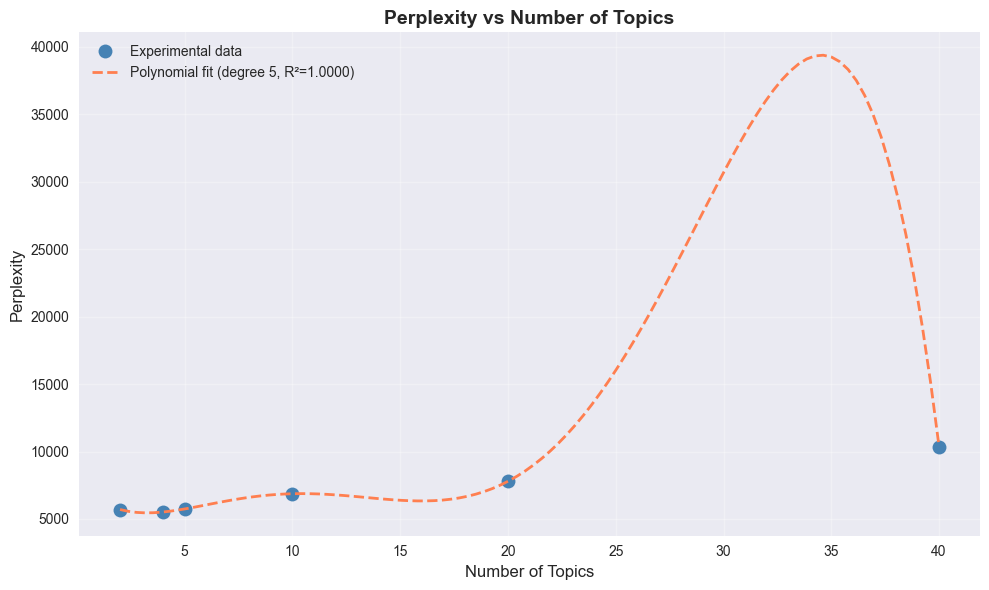


Polynomial Approximation Results:
  Best degree: 5
  R-squared: 1.0000
  Coefficients: [ 0.00000000e+00 -1.69262717e+03  4.18655360e+02 -3.84499570e+01
  1.44898975e+00 -1.80477263e-02]


In [6]:
# Plot perplexity vs topics with polynomial approximation
coefs, r2, degree, best_reg, best_poly_features = plot_perplexity_vs_topics(results)

print(f"\nPolynomial Approximation Results:")
print(f"  Best degree: {degree}")
print(f"  R-squared: {r2:.4f}")
print(f"  Coefficients: {coefs}")


## Step 6: Task 3 - Find Optimal Number of Topics

Determine the optimal number of topics using different methods.


In [7]:
# Find optimal number of topics
optimal_topics_elbow = find_optimal_topics(results, method='elbow')
optimal_topics_min = find_optimal_topics(results, method='min_perplexity')

print("=" * 60)
print("Optimal Number of Topics Analysis")
print("=" * 60)
print(f"\nElbow method: {optimal_topics_elbow} topics")
print(f"Minimum perplexity: {optimal_topics_min} topics")

# Show perplexity for each configuration
print("\nPerplexity by number of topics:")
print("-" * 60)
for r in sorted(results, key=lambda x: x['n_topics']):
    print(f"  {r['n_topics']:2d} topics: {r['perplexity']:8.2f}")


Optimal Number of Topics Analysis

Elbow method: 20 topics
Minimum perplexity: 4 topics

Perplexity by number of topics:
------------------------------------------------------------
   2 topics:  5702.25
   4 topics:  5517.51
   5 topics:  5744.09
  10 topics:  6872.30
  20 topics:  7793.45
  40 topics: 10370.69


## Step 7: Document-Topic Probability Analysis

Examine document-topic probability distributions for the optimal model.


In [8]:
# Get document-topic distribution for optimal model
optimal_result = next((r for r in results if r['n_topics'] == optimal_topics_elbow), results[0])
doc_topic_dist = np.array(optimal_result['doc_topic_distribution'])

print(f"Document-topic distribution shape: {doc_topic_dist.shape}")
print(f"Number of documents: {doc_topic_dist.shape[0]}")
print(f"Number of topics: {doc_topic_dist.shape[1]}")

# Show statistics
print("\nTopic probability statistics:")
print("-" * 60)
for topic_idx in range(doc_topic_dist.shape[1]):
    topic_probs = doc_topic_dist[:, topic_idx]
    print(f"Topic {topic_idx}: mean={np.mean(topic_probs):.4f}, "
          f"std={np.std(topic_probs):.4f}, max={np.max(topic_probs):.4f}")


Document-topic distribution shape: (97507, 20)
Number of documents: 97507
Number of topics: 20

Topic probability statistics:
------------------------------------------------------------
Topic 0: mean=0.0546, std=0.1520, max=0.9683
Topic 1: mean=0.0590, std=0.1572, max=0.9721
Topic 2: mean=0.0401, std=0.1234, max=0.9721
Topic 3: mean=0.0703, std=0.1863, max=0.9712
Topic 4: mean=0.0430, std=0.1221, max=0.9721
Topic 5: mean=0.0336, std=0.1055, max=0.9672
Topic 6: mean=0.0313, std=0.0992, max=0.9694
Topic 7: mean=0.0321, std=0.1064, max=0.9703
Topic 8: mean=0.0468, std=0.1404, max=0.9712
Topic 9: mean=0.0452, std=0.1242, max=0.9661
Topic 10: mean=0.0769, std=0.1777, max=0.9694
Topic 11: mean=0.0399, std=0.1284, max=0.9672
Topic 12: mean=0.0392, std=0.1226, max=0.9672
Topic 13: mean=0.0530, std=0.1492, max=0.9743
Topic 14: mean=0.0453, std=0.1329, max=0.9694
Topic 15: mean=0.0560, std=0.1642, max=0.9750
Topic 16: mean=0.0729, std=0.1850, max=0.9703
Topic 17: mean=0.0652, std=0.1695, max=0.

## Step 8: Top Documents per Topic

Show documents with highest probability for each topic.


In [9]:
# Display top documents for each topic
print(f"Top 5 documents for each topic (n_topics={optimal_result['n_topics']}):")
print("=" * 60)

for topic_id, docs in optimal_result['top_documents'].items():
    print(f"\nTopic {topic_id}:")
    for i, (doc_idx, prob) in enumerate(docs[:5], 1):
        print(f"  {i}. Document {doc_idx:5d} (probability: {prob:.4f})")


Top 5 documents for each topic (n_topics=20):

Topic 0:
  1. Document 78360 (probability: 0.9683)
  2. Document 46691 (probability: 0.9661)
  3. Document 22422 (probability: 0.9648)
  4. Document 59564 (probability: 0.9620)
  5. Document 68037 (probability: 0.9604)

Topic 1:
  1. Document 78587 (probability: 0.9721)
  2. Document 75504 (probability: 0.9712)
  3. Document 75750 (probability: 0.9703)
  4. Document 23121 (probability: 0.9703)
  5. Document 17642 (probability: 0.9703)

Topic 2:
  1. Document  3087 (probability: 0.9721)
  2. Document  6060 (probability: 0.9712)
  3. Document 87643 (probability: 0.9703)
  4. Document 34256 (probability: 0.9683)
  5. Document 62284 (probability: 0.9683)

Topic 3:
  1. Document 81464 (probability: 0.9712)
  2. Document 28739 (probability: 0.9712)
  3. Document 41432 (probability: 0.9703)
  4. Document 69048 (probability: 0.9703)
  5. Document 10375 (probability: 0.9694)

Topic 4:
  1. Document 84894 (probability: 0.9721)
  2. Document 78955 (p

## Step 9: Optional - Iteration Count Experiments

Test different numbers of training iterations to find optimal value.


In [10]:
# Test different iteration counts
base_iter = 10
n_iters_list = [base_iter // 2, base_iter, base_iter * 2]
test_n_topics = optimal_topics_elbow

print(f"Testing iteration counts: {n_iters_list}")
print(f"Using {test_n_topics} topics (optimal from previous experiments)")

iter_results = run_iteration_experiments(
    train_matrix, test_matrix,
    vocabulary, test_n_topics,
    n_iters_list
)


Testing iteration counts: [5, 10, 20]
Using 20 topics (optimal from previous experiments)

Iteration experiment: n_topics=20, n_iter=5
  Perplexity: 9727.68, Time: 24.57s

Iteration experiment: n_topics=20, n_iter=10
  Perplexity: 7793.45, Time: 35.45s

Iteration experiment: n_topics=20, n_iter=20
  Perplexity: 7275.22, Time: 52.23s


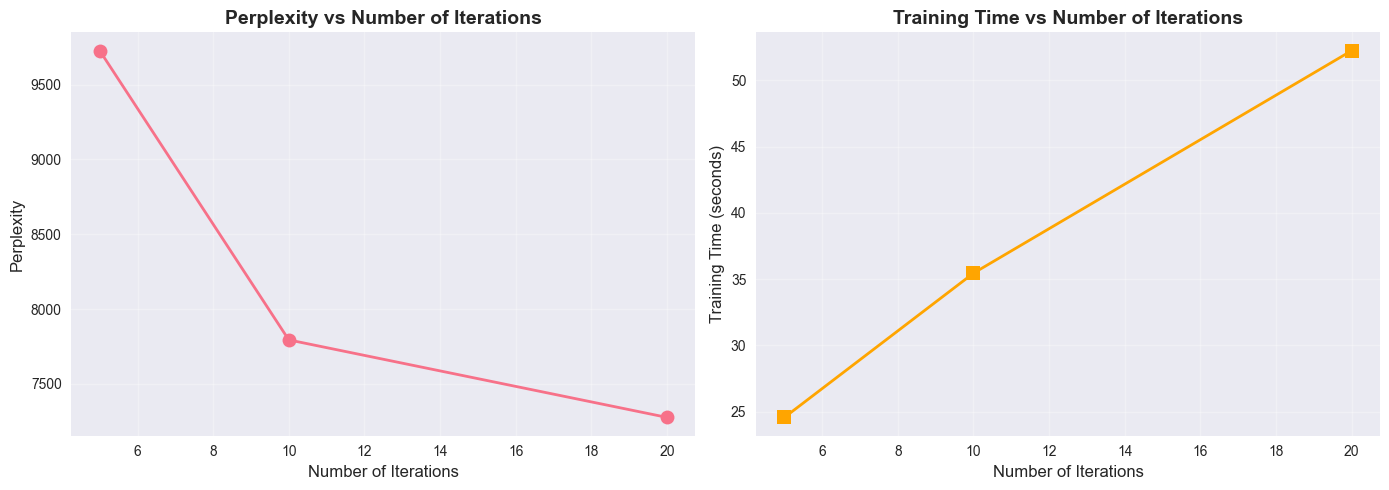


Optimal number of iterations: 20
  Perplexity: 7275.22
  Training time: 52.23s


In [11]:
# Visualize iteration results
iter_df = pd.DataFrame(iter_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Perplexity vs iterations
axes[0].plot(iter_df['n_iter'], iter_df['perplexity'], marker='o', linewidth=2, markersize=10)
axes[0].set_xlabel('Number of Iterations', fontsize=12)
axes[0].set_ylabel('Perplexity', fontsize=12)
axes[0].set_title('Perplexity vs Number of Iterations', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Training time vs iterations
axes[1].plot(iter_df['n_iter'], iter_df['training_time'], marker='s', linewidth=2, markersize=10, color='orange')
axes[1].set_xlabel('Number of Iterations', fontsize=12)
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('Training Time vs Number of Iterations', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal iterations
best_iter_result = min(iter_results, key=lambda x: x['perplexity'])
print(f"\nOptimal number of iterations: {best_iter_result['n_iter']}")
print(f"  Perplexity: {best_iter_result['perplexity']:.2f}")
print(f"  Training time: {best_iter_result['training_time']:.2f}s")


## Step 10: Save Results

Save experiment results and document-topic distributions.


In [12]:
# Save results
os.makedirs('assets/results', exist_ok=True)
os.makedirs('assets/results/distributions', exist_ok=True)

# Save experiment results
results_file = 'assets/results/lda_experiments.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2)
print(f"Saved experiment results to {results_file}")

# Save document-topic distributions in TSV format
for result in results:
    n_topics = result['n_topics']
    doc_topic_dist = np.array(result['doc_topic_distribution'])
    
    output_file = f'assets/results/distributions/doc_topic_dist_n_topics_{n_topics}.tsv'
    with open(output_file, 'w', encoding='utf-8') as f:
        for doc_idx, probs in enumerate(doc_topic_dist):
            doc_id = str(doc_idx)
            prob_str = '\t'.join([f"{p:.6f}" for p in probs])
            f.write(f"{doc_id}\t{prob_str}\n")
    
    print(f"Saved document-topic distribution to {output_file}")

print("\nAll results saved successfully!")


Saved experiment results to assets/results/lda_experiments.json
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_2.tsv
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_4.tsv
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_5.tsv
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_10.tsv
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_20.tsv
Saved document-topic distribution to assets/results/distributions/doc_topic_dist_n_topics_40.tsv

All results saved successfully!
